In [1]:
import time
import os, scipy
import torch   
import scipy.sparse as sp 
import numpy as np  
import torch.nn.functional as F 
import pickle
import numpy.random as random
import matplotlib.pyplot as plt 
from math import *
from numpy import transpose,matrix,exp,conj
from numpy.linalg import inv 
from src_lwt.util_final import * 
import torch.nn as nn
from load_data import *
from PPGN import *

In [2]:
if True: 
    np_load_old = np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k) 
    data = np.load('./data/info.npy')
    bus_dict = data[0]  
    bus_phase= data[1] 
    load_phase= data[3]  
    fault_bus_list = sorted(list(bus_dict.keys())) 
    bus_to_index = dict((bus, index) for index, bus in enumerate(fault_bus_list))#  
    index_to_bus = dict((index, bus) for bus, index in bus_to_index.items())
    singlePhaseBus = [bus for bus, phases in bus_phase.items() if len(phases) == 1]
    singlePhaseIndex = [bus_to_index[i] for i in singlePhaseBus] 

In [5]:
# parameters  
dropout = 0
dropout_outlayer = 0 
root = "./data/" 
num_node = 128   
dim_input = 6
num_labelper = 33
agg_func = "MEAN"
epochs =  100 
b_sz = 32
global seed
seed = 842 
learn_method = 'sup' 
max_vali_f1 = 0  
hidden_emb_size = [32,32,32] 
num_layers = len(hidden_emb_size) 
dataSet = 'loc'
ds = dataSet
device = torch.device("cuda" if  torch.cuda.is_available() else "cpu") 
random.seed( seed)
np.random.seed( seed)
torch.manual_seed( seed)
torch.cuda.manual_seed_all( seed)
lr = 0.001
weight_name = 'A_short' 
k=3  
measured_index =[73, 94, 105, 118, 72, 79, 24, 41, 69, 90, 84, 78, 122, 49, 66, 104, 109, 10, 36, 31, 85]
dataC = dataCenter(num_labelper,seed, measured_index)   
A, prob_A = select_A_prob(k, 'A_short') # option 1: 'A_short': using shortest path 'A_adam': using admittance matrix
nodes_layers  = dic_nodes_neib(num_layers,A,prob_A )   


modelname =   str(num_labelper) + '_all_'  + '.pkl'
saveroot = "./"
savepath = os.path.join(saveroot, modelname ) 
savebest = os.path.join(os.path.join(saveroot, '00_saved_final'), learn_method + '_'+ str(num_labelper) + '_all_' +str(len(measured_index)) + '.pkl') 
retrain =     True  
#load data
features, labels, ind_train ,  ind_test,    neib_observ,ind_labels, ind_measured= load_all_types( num_labelper , measured_index,seed = seed )
with open(os.path.join(root, 'neib.pickle'), 'rb') as f:
    dic = pickle.load(f)
neib  = dic['neib']

In [9]:
#Establish PPGN
graph_stageI = GraphSage(num_layers, dim_input,hidden_emb_size  ,   A, prob_A, dropout = dropout ,device = device,    agg_method= agg_func  )
graph_stageI.to(device) 
classification = Outlayer_fully( hidden_emb_size[-1],  num_node,  dropout = dropout_outlayer) 
classification.to(device)
models = [graph_stageI, classification]
params = []
for model in models:
    for param in model.parameters():
        if param.requires_grad:
            params.append(param)
optimizer = torch.optim.Adam(params, lr = lr, weight_decay = 5e-3)  
if retrain:
    models, optimizer, start_epoch = load_checkpoint(models, optimizer, savebest) 
    graph_stageI, classification  = models[0], models[1]

=> loading checkpoint './00_saved_final/sup_33_all_21.pkl'
=> loaded checkpoint './00_saved_final/sup_33_all_21.pkl' (epoch 499)


In [10]:
# load the saved model
models, optimizer, start_epoch = load_checkpoint(models, optimizer , savebest)
graph_stageI, classification = models[0], models[1]
labels_neib = one_hot_neib(labels, neib )
models = [graph_stageI, classification]
params = []
for model in models:
    for param in model.parameters():
        if param.requires_grad:
            param.requires_grad = False
            params.append(param)

embs = graph_stageI( nodes_layers ,features)
logists =  classification(embs)
predicts = torch.max(logists, 1)[1]
labels_test = labels[ind_test] 
labels_neib_test = labels_neib[ind_test]
assert len(labels[ind_test] ) == len(predicts[ind_test]  ) 
test_f1 = f1_score(labels[ind_test] , predicts[ind_test].cpu().data, average="macro")
acc = accuracy_score(labels_test, predicts[ind_test].cpu().data)
acc_neib = hop_acc(labels_neib_test, predicts[ind_test].cpu().data)
print("Test F1:%.4f,  Acc:%.4f, Acc 1 hop: %.4f " %(test_f1, acc, acc_neib))  

=> loading checkpoint './00_saved_final/sup_33_all_21.pkl'
=> loaded checkpoint './00_saved_final/sup_33_all_21.pkl' (epoch 499)
Test F1:0.9765,  Acc:0.9779, Acc 1 hop: 0.9806 


In [11]:
# stage II parameters
A_119 = A_labels(A )
Adj = constructW_stageI(embs , logists  ,A_119, 120 )
features_X = torch.reshape(features, [features.shape[0],features.shape[1] *features.shape[2] ])
seed = 42; epochs =300
lr = 0.001
weight_decay = 5e-5
batch_size = 32
hidden = [128*3,128*3, 128*3 ]
dropout =0 
fastmode = False
np.random.seed(seed)
torch.manual_seed( seed)   
retrain2= False

In [12]:
model2 = GCN(nfeat=features_X.shape[1],
            nhid= hidden,
            nclass=119, 
            dropout= dropout)
optimizer2 = torch.optim.Adam(model2.parameters(),
                       lr= lr, weight_decay= weight_decay) 
model_name =  'StageII_all' + str(num_labelper) + '_.pkl'
newname = 'StageII_all' + str(num_labelper) + '_.pkl'
savepath2 = os.path.join(saveroot, model_name) 
savebest2 = os.path.join(saveroot, newname) 
if retrain2:
    model2.load_state_dict(torch.load(savepath2)['state_dict'] )   
    optimizer2.load_state_dict(torch.load(savepath2)['optimizer'] )   

Epoch: 0001 loss_train: 4.7916 acc_train: 0.0100 loss_val: 4.6885 acc_val: 0.0316 time: 3.0135s
Test set results: loss= 4.6847 accuracy= 0.0350 1-hop accuracy = 0.0998
Epoch: 0002 loss_train: 4.6885 acc_train: 0.0316 loss_val: 4.5963 acc_val: 0.0519 time: 2.8297s
Test set results: loss= 4.5883 accuracy= 0.0580 1-hop accuracy = 0.1076
Epoch: 0003 loss_train: 4.5963 acc_train: 0.0519 loss_val: 4.5059 acc_val: 0.0482 time: 2.8227s
Test set results: loss= 4.4942 accuracy= 0.0568 1-hop accuracy = 0.0965
Epoch: 0004 loss_train: 4.5059 acc_train: 0.0482 loss_val: 4.4127 acc_val: 0.0500 time: 2.7729s
Test set results: loss= 4.3976 accuracy= 0.0594 1-hop accuracy = 0.1065
Epoch: 0005 loss_train: 4.4127 acc_train: 0.0500 loss_val: 4.3163 acc_val: 0.0500 time: 2.9354s
Test set results: loss= 4.2985 accuracy= 0.0595 1-hop accuracy = 0.1074
Epoch: 0006 loss_train: 4.3163 acc_train: 0.0500 loss_val: 4.2187 acc_val: 0.0500 time: 2.9370s
Test set results: loss= 4.1977 accuracy= 0.0592 1-hop accuracy =

Epoch: 0050 loss_train: 2.2500 acc_train: 0.4596 loss_val: 2.2220 acc_val: 0.4609 time: 2.7763s
Test set results: loss= 2.1046 accuracy= 0.5022 1-hop accuracy = 0.6846
Epoch: 0051 loss_train: 2.2220 acc_train: 0.4609 loss_val: 2.1946 acc_val: 0.4638 time: 2.7811s
Test set results: loss= 2.0797 accuracy= 0.5060 1-hop accuracy = 0.6901
Epoch: 0052 loss_train: 2.1946 acc_train: 0.4638 loss_val: 2.1678 acc_val: 0.4655 time: 2.7970s
Test set results: loss= 2.0550 accuracy= 0.5064 1-hop accuracy = 0.6934
Epoch: 0053 loss_train: 2.1678 acc_train: 0.4655 loss_val: 2.1418 acc_val: 0.4675 time: 2.7931s
Test set results: loss= 2.0313 accuracy= 0.5078 1-hop accuracy = 0.6941
Epoch: 0054 loss_train: 2.1418 acc_train: 0.4675 loss_val: 2.1161 acc_val: 0.4716 time: 2.8242s
Test set results: loss= 2.0086 accuracy= 0.5109 1-hop accuracy = 0.6989
Epoch: 0055 loss_train: 2.1161 acc_train: 0.4716 loss_val: 2.0909 acc_val: 0.4735 time: 2.7895s
Test set results: loss= 1.9870 accuracy= 0.5139 1-hop accuracy =

Epoch: 0099 loss_train: 1.3841 acc_train: 0.6062 loss_val: 1.3726 acc_val: 0.6152 time: 2.9357s
Test set results: loss= 1.3925 accuracy= 0.6148 1-hop accuracy = 0.8524
Epoch: 0100 loss_train: 1.3726 acc_train: 0.6152 loss_val: 1.3620 acc_val: 0.6205 time: 2.9743s
Test set results: loss= 1.3855 accuracy= 0.6172 1-hop accuracy = 0.8569
Epoch: 0101 loss_train: 1.3620 acc_train: 0.6205 loss_val: 1.3529 acc_val: 0.6172 time: 2.9666s
Test set results: loss= 1.3800 accuracy= 0.6154 1-hop accuracy = 0.8585
Epoch: 0102 loss_train: 1.3529 acc_train: 0.6172 loss_val: 1.3423 acc_val: 0.6221 time: 3.0285s
Test set results: loss= 1.3709 accuracy= 0.6183 1-hop accuracy = 0.8572
Epoch: 0103 loss_train: 1.3423 acc_train: 0.6221 loss_val: 1.3315 acc_val: 0.6269 time: 2.9658s
Test set results: loss= 1.3644 accuracy= 0.6231 1-hop accuracy = 0.8638
Epoch: 0104 loss_train: 1.3315 acc_train: 0.6269 loss_val: 1.3224 acc_val: 0.6252 time: 2.9534s
Test set results: loss= 1.3600 accuracy= 0.6199 1-hop accuracy =

Epoch: 0148 loss_train: 1.0240 acc_train: 0.6968 loss_val: 1.0185 acc_val: 0.6949 time: 3.2523s
Test set results: loss= 1.1903 accuracy= 0.6658 1-hop accuracy = 0.9337
Epoch: 0149 loss_train: 1.0185 acc_train: 0.6949 loss_val: 1.0146 acc_val: 0.6914 time: 3.1884s
Test set results: loss= 1.1890 accuracy= 0.6641 1-hop accuracy = 0.9306
Epoch: 0150 loss_train: 1.0146 acc_train: 0.6914 loss_val: 1.0098 acc_val: 0.6989 time: 3.2090s
Test set results: loss= 1.1831 accuracy= 0.6730 1-hop accuracy = 0.9416
Epoch: 0151 loss_train: 1.0098 acc_train: 0.6989 loss_val: 1.0043 acc_val: 0.6958 time: 3.2282s
Test set results: loss= 1.1845 accuracy= 0.6672 1-hop accuracy = 0.9350
Epoch: 0152 loss_train: 1.0043 acc_train: 0.6958 loss_val: 1.0001 acc_val: 0.6986 time: 3.2360s
Test set results: loss= 1.1830 accuracy= 0.6664 1-hop accuracy = 0.9355
Epoch: 0153 loss_train: 1.0001 acc_train: 0.6986 loss_val: 0.9959 acc_val: 0.7004 time: 3.2116s
Test set results: loss= 1.1778 accuracy= 0.6762 1-hop accuracy =

Epoch: 0197 loss_train: 0.8439 acc_train: 0.7215 loss_val: 0.8412 acc_val: 0.7249 time: 3.3412s
Test set results: loss= 1.1295 accuracy= 0.6958 1-hop accuracy = 0.9629
Epoch: 0198 loss_train: 0.8412 acc_train: 0.7249 loss_val: 0.8386 acc_val: 0.7239 time: 3.3093s
Test set results: loss= 1.1289 accuracy= 0.6940 1-hop accuracy = 0.9596
Epoch: 0199 loss_train: 0.8386 acc_train: 0.7239 loss_val: 0.8358 acc_val: 0.7264 time: 3.3098s
Test set results: loss= 1.1289 accuracy= 0.6972 1-hop accuracy = 0.9633
Epoch: 0200 loss_train: 0.8358 acc_train: 0.7264 loss_val: 0.8332 acc_val: 0.7243 time: 3.3061s
Test set results: loss= 1.1265 accuracy= 0.6955 1-hop accuracy = 0.9626
Epoch: 0201 loss_train: 0.8332 acc_train: 0.7243 loss_val: 0.8306 acc_val: 0.7264 time: 3.3078s
Test set results: loss= 1.1293 accuracy= 0.6954 1-hop accuracy = 0.9619
Epoch: 0202 loss_train: 0.8306 acc_train: 0.7264 loss_val: 0.8281 acc_val: 0.7269 time: 3.2950s
Test set results: loss= 1.1258 accuracy= 0.6959 1-hop accuracy =

Epoch: 0246 loss_train: 0.7424 acc_train: 0.7431 loss_val: 0.7409 acc_val: 0.7394 time: 3.3536s
Test set results: loss= 1.1258 accuracy= 0.6962 1-hop accuracy = 0.9609
Epoch: 0247 loss_train: 0.7409 acc_train: 0.7394 loss_val: 0.7390 acc_val: 0.7408 time: 3.3552s
Test set results: loss= 1.1246 accuracy= 0.6963 1-hop accuracy = 0.9629
Epoch: 0248 loss_train: 0.7390 acc_train: 0.7408 loss_val: 0.7373 acc_val: 0.7400 time: 3.3431s
Test set results: loss= 1.1283 accuracy= 0.6950 1-hop accuracy = 0.9605
Epoch: 0249 loss_train: 0.7373 acc_train: 0.7400 loss_val: 0.7360 acc_val: 0.7392 time: 3.3314s
Test set results: loss= 1.1226 accuracy= 0.6969 1-hop accuracy = 0.9620
Epoch: 0250 loss_train: 0.7360 acc_train: 0.7392 loss_val: 0.7349 acc_val: 0.7422 time: 3.3618s
Test set results: loss= 1.1318 accuracy= 0.6944 1-hop accuracy = 0.9597
Epoch: 0251 loss_train: 0.7349 acc_train: 0.7422 loss_val: 0.7339 acc_val: 0.7381 time: 3.3420s
Test set results: loss= 1.1220 accuracy= 0.6979 1-hop accuracy =

Epoch: 0295 loss_train: 0.6782 acc_train: 0.7511 loss_val: 0.6778 acc_val: 0.7538 time: 3.4276s
Test set results: loss= 1.1468 accuracy= 0.6981 1-hop accuracy = 0.9643
Epoch: 0296 loss_train: 0.6778 acc_train: 0.7538 loss_val: 0.6776 acc_val: 0.7536 time: 3.4259s
Test set results: loss= 1.1497 accuracy= 0.6953 1-hop accuracy = 0.9613
Epoch: 0297 loss_train: 0.6776 acc_train: 0.7536 loss_val: 0.6760 acc_val: 0.7485 time: 3.5029s
Test set results: loss= 1.1484 accuracy= 0.6993 1-hop accuracy = 0.9627
Epoch: 0298 loss_train: 0.6760 acc_train: 0.7485 loss_val: 0.6740 acc_val: 0.7553 time: 3.4243s
Test set results: loss= 1.1485 accuracy= 0.6961 1-hop accuracy = 0.9604
Epoch: 0299 loss_train: 0.6740 acc_train: 0.7553 loss_val: 0.6728 acc_val: 0.7502 time: 3.4089s
Test set results: loss= 1.1501 accuracy= 0.6967 1-hop accuracy = 0.9620
Epoch: 0300 loss_train: 0.6728 acc_train: 0.7502 loss_val: 0.6720 acc_val: 0.7571 time: 3.4711s
Test set results: loss= 1.1496 accuracy= 0.6967 1-hop accuracy =

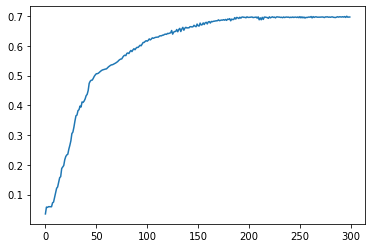

In [14]:
# Train model  
t_total = time.time()
acc_epoch = []
best_acc = 0
start = time.time()
for epoch in range(300):  
    acc_train = train( model2,optimizer2,  features_X    , labels   , Adj, ind_train, fastmode, ind_train, batch_size)
    acc_test, acc_hop = test(model2, features_X , labels ,A_119, Adj, ind_test)
    acc_epoch.append(acc_test.numpy())
    if acc_test.numpy() > best_acc:
        best_acc = acc_test.numpy() 
        state = {'epoch': epoch + 1, 'state_dict': model2.state_dict() ,
             'optimizer': optimizer2.state_dict() }
        torch.save(state, savepath2)
print("Optimization Finished!") 
print('The max acc is %.4f' %np.max(acc_epoch))  
print('The test max acc is %.4f' %np.max(acc_epoch))
print('The test argmax acc is %2d' %np.argmax(acc_epoch)) 